In [58]:
## Installing all the necessary libraries 
#!pip install tensorflow
#!pip install scikit-learn
#!pip install pandas
#!pip install numpy
#!pip install seaborn
#!pip install matplotlib 
#!pip install wordcloud
#!pip install nltk

## Load Libraries

In [59]:
# DL packages
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [60]:
# ML packages
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import pickle
import nltk
import re
from nltk.stem import PorterStemmer

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

## Load Data

In [61]:
train_data = pd.read_csv('train.txt', header=None, sep=';', names=['comment','emotion'], encoding='utf-8')

In [62]:
train_data

,comment,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


In [63]:
train_data['length'] = [len(x) for x in train_data['comment']]
train_data

,comment,emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,101
15996,i am now turning and i feel pathetic that i am...,sadness,102
15997,i feel strong and good overall,joy,30
15998,i feel like this was such a rude comment and i...,anger,59


In [64]:
train_data.shape

(16000, 3)

In [65]:
train_data.isnull().sum()
## No missing values

comment    0
emotion    0
length     0
dtype: int64

In [66]:
train_data.duplicated().sum()

1

In [67]:
train_data.drop_duplicates(inplace=True)

## EDA

In [68]:
train_data['emotion'].value_counts()
# Data is imbalenced

emotion
joy         5361
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

<Axes: xlabel='emotion', ylabel='count'>

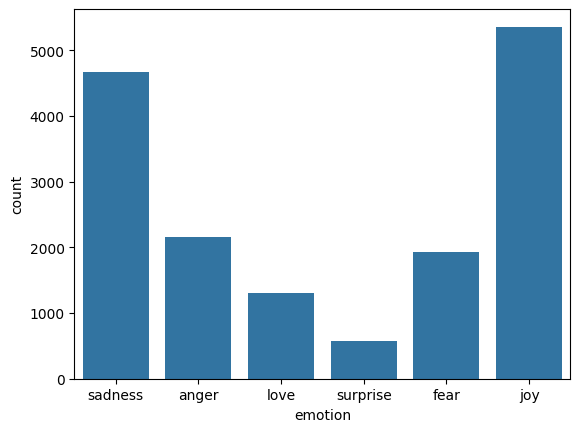

In [69]:
sns.countplot(x=train_data['emotion'])

<Axes: xlabel='length', ylabel='Count'>

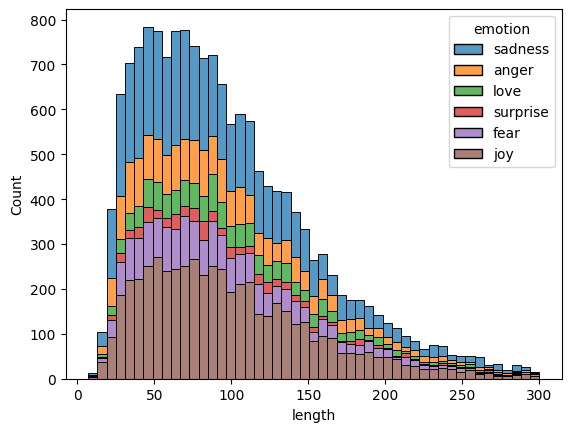

In [70]:
# Checking the distribution of data
df = train_data.copy()
length_values = df['length'].values
sns.histplot(data=df, x='length', hue='emotion', multiple='stack')
# Data is Right skewed

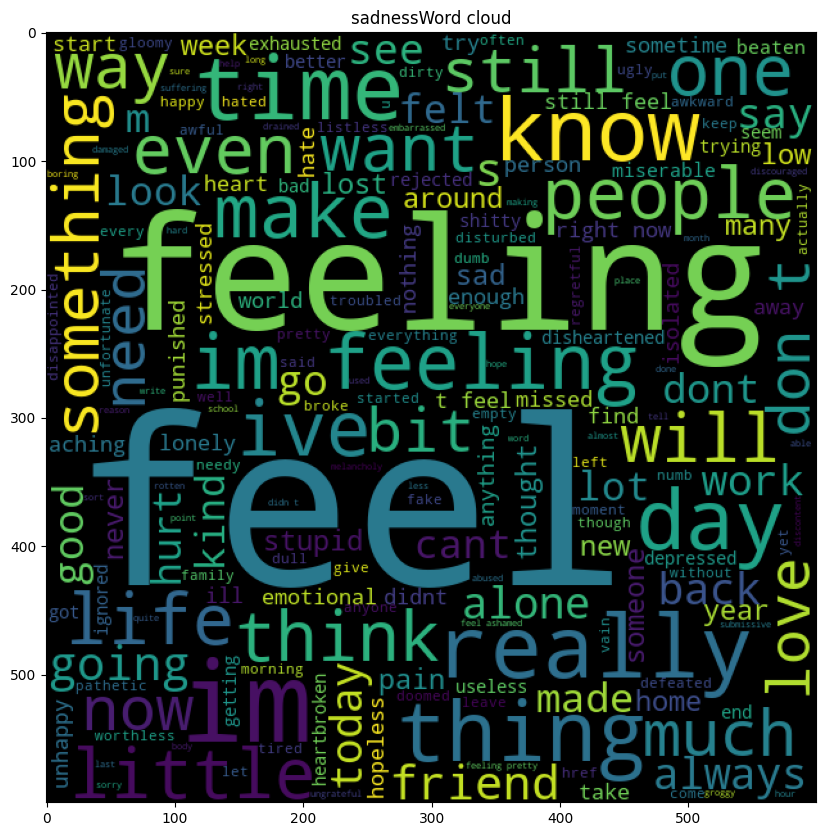

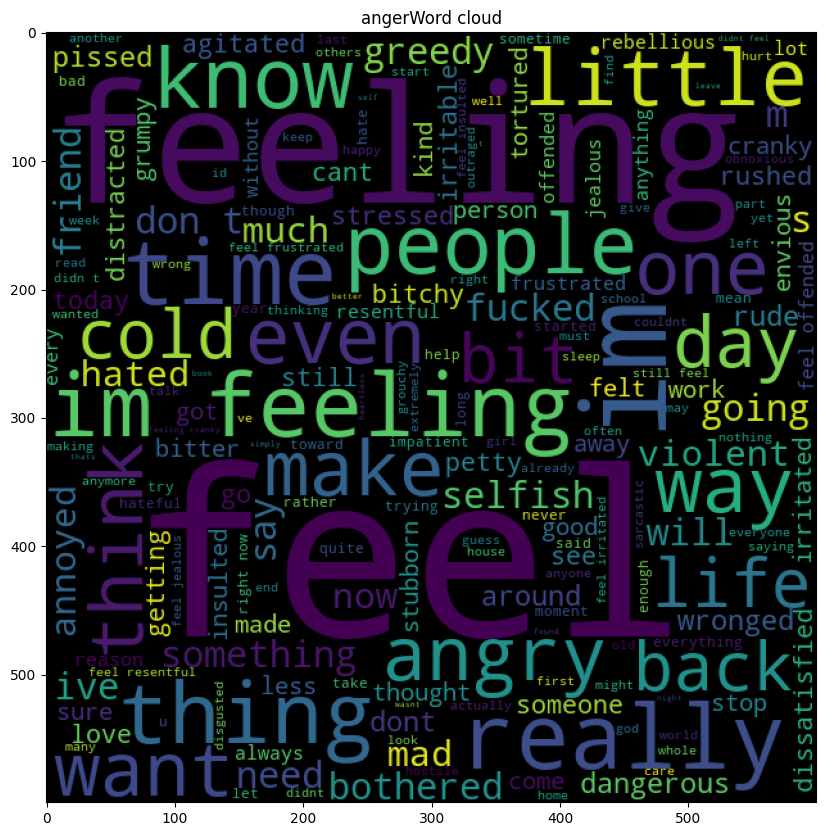

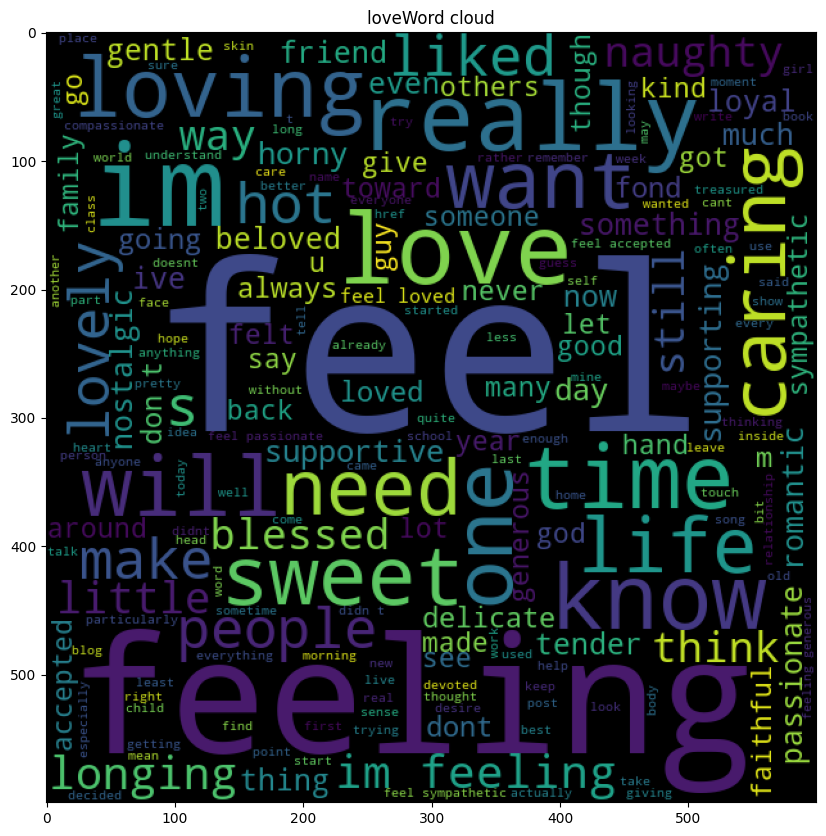

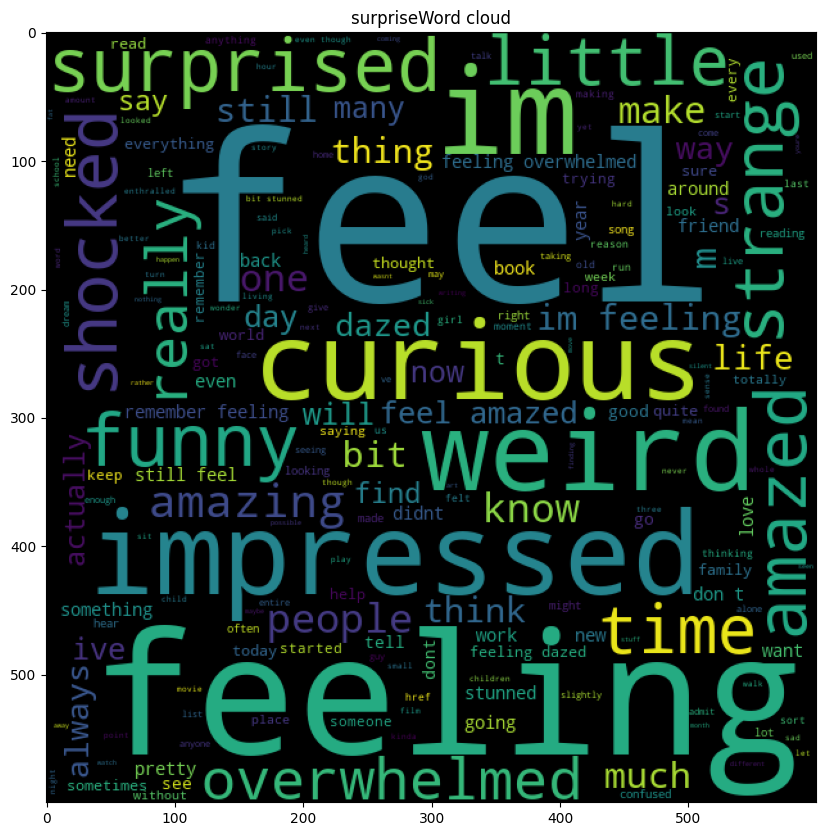

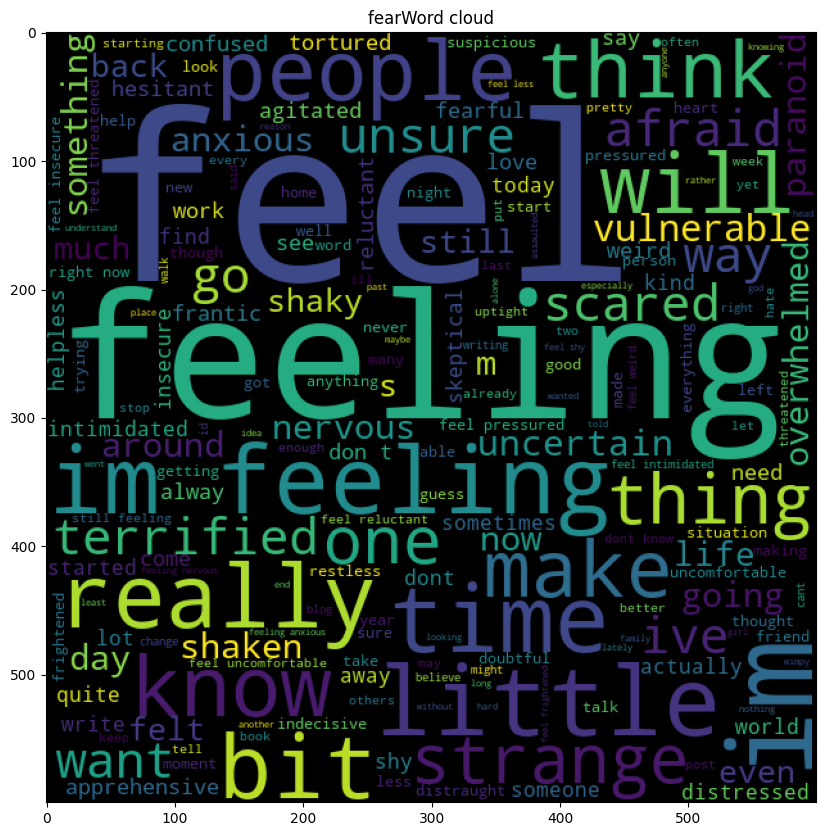

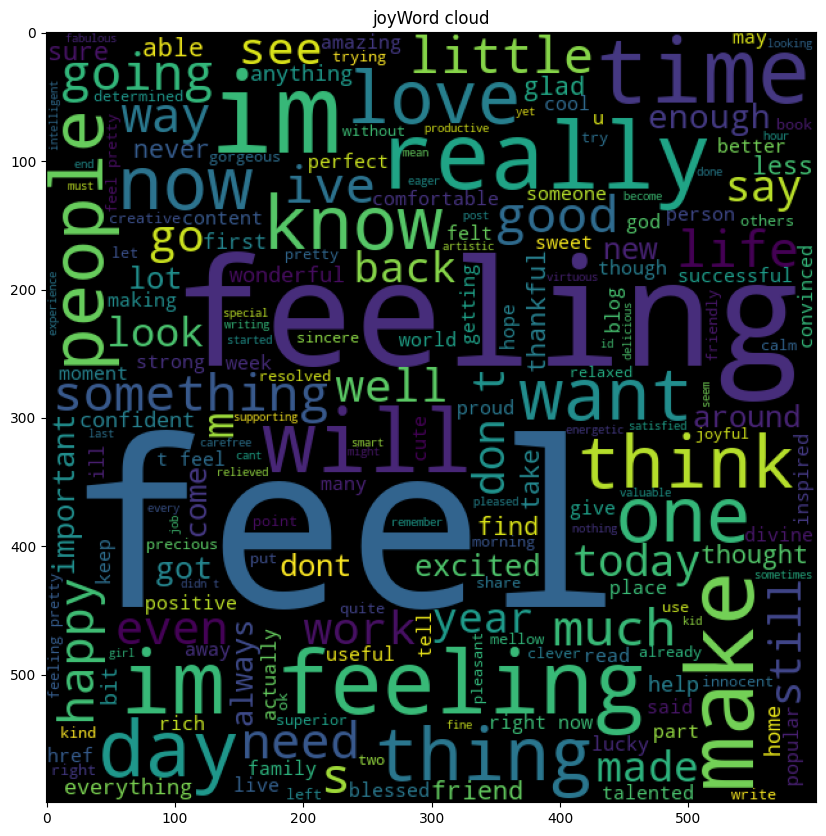

In [71]:
# Word cloud is used to represent text data visually
def words_cloud(wordcloud, df):
    plt.figure(figsize=(10,10))
    plt.title(emotion+"Word cloud")
    plt.imshow(wordcloud)
    
emotions_list = train_data.emotion.unique()
for emotion in emotions_list:
    text = " ".join([sentence for sentence in train_data.loc[train_data['emotion']==emotion,'comment']])
    wordcloud = WordCloud(width=600, height=600).generate(text)
    words_cloud(wordcloud, emotion)

# Size of word directly proportional to the frequency of the words used in sentence

# Data Preprocessing

### Encode Emotions

In [72]:
train_data

,comment,emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,101
15996,i am now turning and i feel pathetic that i am...,sadness,102
15997,i feel strong and good overall,joy,30
15998,i feel like this was such a rude comment and i...,anger,59


In [73]:
lb = LabelEncoder()
train_data['emotion_encodded'] = lb.fit_transform(train_data['emotion'])
train_data
## Here we give labels to every emotion

,comment,emotion,length,emotion_encodded
0,i didnt feel humiliated,sadness,23,4
1,i can go from feeling so hopeless to so damned...,sadness,108,4
2,im grabbing a minute to post i feel greedy wrong,anger,48,0
3,i am ever feeling nostalgic about the fireplac...,love,92,3
4,i am feeling grouchy,anger,20,0
...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,101,4
15996,i am now turning and i feel pathetic that i am...,sadness,102,4
15997,i feel strong and good overall,joy,30,2
15998,i feel like this was such a rude comment and i...,anger,59,0


### Applying machine learning

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [75]:
df = train_data.copy()

In [76]:
df

,comment,emotion,length,emotion_encodded
0,i didnt feel humiliated,sadness,23,4
1,i can go from feeling so hopeless to so damned...,sadness,108,4
2,im grabbing a minute to post i feel greedy wrong,anger,48,0
3,i am ever feeling nostalgic about the fireplac...,love,92,3
4,i am feeling grouchy,anger,20,0
...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,101,4
15996,i am now turning and i feel pathetic that i am...,sadness,102,4
15997,i feel strong and good overall,joy,30,2
15998,i feel like this was such a rude comment and i...,anger,59,0


In [77]:
# Data cleaning and preprocessing
# download nltk stopwords
#nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
stopwords

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [78]:
def clean_text(text):
    stemmer = PorterStemmer()
    text = re.sub("[^a-zA-Z]"," ",text)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    return " ".join(text) 

In [79]:
# checking the function
clean_text("I am 3435 &^ loving hated studying ")

'love hate studi'

In [80]:
df['cleaned_comment'] = df['comment'].apply(clean_text)

In [81]:
df

,comment,emotion,length,emotion_encodded,cleaned_comment
0,i didnt feel humiliated,sadness,23,4,didnt feel humili
1,i can go from feeling so hopeless to so damned...,sadness,108,4,go feel hopeless damn hope around someon care ...
2,im grabbing a minute to post i feel greedy wrong,anger,48,0,im grab minut post feel greedi wrong
3,i am ever feeling nostalgic about the fireplac...,love,92,3,ever feel nostalg fireplac know still properti
4,i am feeling grouchy,anger,20,0,feel grouchi
...,...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,101,4,brief time beanbag said anna feel like beaten
15996,i am now turning and i feel pathetic that i am...,sadness,102,4,turn feel pathet still wait tabl sub teach degre
15997,i feel strong and good overall,joy,30,2,feel strong good overal
15998,i feel like this was such a rude comment and i...,anger,59,0,feel like rude comment im glad


In [82]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_comment'],df['emotion_encodded'],test_size=0.2,random_state=65)

In [83]:
X_train.shape, y_test.shape

((12799,), (3200,))

In [84]:
# Vectorization using Tf-idf
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [85]:
classifiers = {
    "MultinomialNB": MultinomialNB(),
    "LogisticRegression": LogisticRegression(),
    "RandomForestClassifier": RandomForestClassifier(),
    "Support Vector Machine": SVC()
}

In [86]:
for name, clf in classifiers.items():
    print(f"\n=================================={name}=============================")
    clf.fit(X_train_tfidf, y_train)
    y_pred_tfidf = clf.predict(X_test_tfidf)
    accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
    print(f"\n Accuracy score is {accuracy_tfidf}")
    print("classification report:")
    print(classification_report(y_test, y_pred_tfidf))


==================================MultinomialNB=============================

 Accuracy score is 0.658125
classification report:
              precision    recall  f1-score   support

           0       0.93      0.30      0.46       434
           1       0.95      0.26      0.41       403
           2       0.60      0.96      0.74      1068
           3       1.00      0.08      0.15       263
           4       0.67      0.90      0.77       917
           5       0.00      0.00      0.00       115

    accuracy                           0.66      3200
   macro avg       0.69      0.42      0.42      3200
weighted avg       0.72      0.66      0.59      3200


==================================LogisticRegression=============================


c:\Users\piyus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\piyus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\piyus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


 Accuracy score is 0.8415625
classification report:
              precision    recall  f1-score   support

           0       0.91      0.78      0.84       434
           1       0.88      0.79      0.83       403
           2       0.80      0.92      0.86      1068
           3       0.80      0.56      0.66       263
           4       0.86      0.93      0.90       917
           5       0.73      0.43      0.54       115

    accuracy                           0.84      3200
   macro avg       0.83      0.74      0.77      3200
weighted avg       0.84      0.84      0.84      3200


==================================RandomForestClassifier=============================

 Accuracy score is 0.849375
classification report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       434
           1       0.84      0.85      0.85       403
           2       0.85      0.87      0.86      1068
           3       0.72      0.67      0.69     

In [87]:
# Selecting Model
lg = LogisticRegression()
lg.fit(X_train_tfidf, y_train)
y_pred_lg = lg.predict(X_test_tfidf)

In [88]:
def predict_emotion(input_text):
    cleaned_text = clean_text(input_text)
    input_vectorized = tfidf.transform([cleaned_text])
    predicted_label = lg.predict(input_vectorized)[0]
    predicted_emotion = lb.inverse_transform([predicted_label])[0]
    label = np.max(lg.predict(input_vectorized)[0])
    return predicted_emotion, label

In [89]:
## Example
sentences = [
    'i didnt feel humilated',
    'i am very happy today',
    'i was crying',
    'i am furious'
]

In [90]:
for sentence in sentences:
    print(sentence)
    emo, label = predict_emotion(sentence)
    print(f"Emotion :{emo}")
    print(f"predicted_label: {label}")

i didnt feel humilated
Emotion :sadness
predicted_label: 4
i am very happy today
Emotion :joy
predicted_label: 2
i was crying
Emotion :joy
predicted_label: 2
i am furious
Emotion :anger
predicted_label: 0


In [91]:
#save files
#pickle.dump(lg,open('logistic_regression.pkl','wb'))
#pickle.dump(lb,open('label_encoder.pkl','wb'))
#pickle.dump(tfidf,open('tfidf_vectorizer.pkl','wb'))



In [92]:
import sklearn
print(sklearn.__version__)

1.4.1.post1


# Applying Deep Learning Using LSTM

### Text cleaning, Encoding and Padding

In [93]:
train_data

,comment,emotion,length,emotion_encodded
0,i didnt feel humiliated,sadness,23,4
1,i can go from feeling so hopeless to so damned...,sadness,108,4
2,im grabbing a minute to post i feel greedy wrong,anger,48,0
3,i am ever feeling nostalgic about the fireplac...,love,92,3
4,i am feeling grouchy,anger,20,0
...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,101,4
15996,i am now turning and i feel pathetic that i am...,sadness,102,4
15997,i feel strong and good overall,joy,30,2
15998,i feel like this was such a rude comment and i...,anger,59,0


In [94]:
def clean_text(df, column, vocab_size, max_len):
    stemmer = PorterStemmer()
    
    corpus = []
    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(w) for w in text if w not in stopwords]
        text = " ".join(text)
        corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=vocab_size) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=max_len, padding='pre')
    return pad

In [95]:
x_train = clean_text(train_data,'comment',vocab_size=11000, max_len=300)

In [96]:
x_train

array([[    0,     0,     0, ...,  4364,  5320,  8090],
       [    0,     0,     0, ...,  9229,  5649,  2860],
       [    0,     0,     0, ...,  5320,  9419,  5390],
       ...,
       [    0,     0,     0, ...,  1397,  6945, 10195],
       [    0,     0,     0, ...,   687,  4263,   351],
       [    0,     0,     0, ...,  5320,  2901,  3356]])

In [97]:
y_train = to_categorical(train_data['emotion_encodded'])

In [98]:
y_train

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]])

## Model Building and Training

In [99]:
model = Sequential()
model.add(Embedding(input_dim=11000, output_dim=150))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
model.fit(x_train,y_train,epochs=5,batch_size=64,verbose=1)

Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 124s 456ms/step - accuracy: 0.3221 - loss: 1.6238
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 109s 325ms/step - accuracy: 0.6646 - loss: 0.9774
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 88s 353ms/step - accuracy: 0.8558 - loss: 0.4266
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 131s 307ms/step - accuracy: 0.9185 - loss: 0.2506
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 117s 468ms/step - accuracy: 0.9396 - loss: 0.1801


### Predictive System

In [101]:
def sentence_cleaning(sentence):
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub("[^a-zA-Z]", " ", sentence)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    text = " ".join(text)
    corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=11000) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=300, padding='pre')
    return pad

In [102]:
sentences = [
            "i feel strong and good overall",
            "im grabbing a minute to post i feel greedy wrong",
            "He was speechles when he found out he was accepted to this new job",
            "This is outrageous, how can you talk like that?",
            "I feel like im all alone in this world",
            "He is really sweet and caring",
            "You made me very crazy",
            "i am ever feeling nostalgic about the fireplace i will know that it is still on the property",
            "i am feeling grouchy",
            "He hates you"
            ]

In [103]:
for sentence in sentences:
    print(sentence)
    sentence = sentence_cleaning(sentence)
    result = lb.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

i feel strong and good overall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
joy : 0.9958481788635254


im grabbing a minute to post i feel greedy wrong
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
anger : 0.9917736649513245


He was speechles when he found out he was accepted to this new job
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
joy : 0.4320797026157379


This is outrageous, how can you talk like that?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
anger : 0.9196591973304749


I feel like im all alone in this world
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
sadness : 0.9932156205177307


He is really sweet and caring
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
love : 0.8634207844734192


You made me very crazy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
anger : 0

### Saving the Model

In [100]:
model.save('model.h5')